Load package and import data

In [2]:
# conda install python-graphviz
# conda install -c conda-forge reverse-geocode 
# conda install -c conda-forge geopandas
# conda install -c conda-forge geoplot
# https://github.com/jupyter/jupyter/issues/245

# Configure matplotlib.
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import scipy as sp
import pandas as pd

import sklearn as sk

import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")
sns.set_color_codes()

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

In [3]:
from dask.distributed import Client, LocalCluster
import dask.bag as db
import dask.dataframe as dd
import dask

from ast import literal_eval
from collections.abc import MutableMapping
from collections import defaultdict
from collections import Counter
import dask.array as da
import os
from operator import itemgetter

import reverse_geocode

In [4]:
cluster = LocalCluster()
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://127.0.0.1:36835 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 20.70 GB


# Loading the dataset

In [5]:
# b = db.read_text("places.clean.json", blocksize="64MiB")
# type(b)

#### Parallel chunks to be processed

In [6]:
# visualize() requires graphviz module
# b.map(literal_eval).to_dataframe().visualize()

#### Load the entire dataframe into memory

In [7]:
%%time
# the entire dataframe
# df = b.map(literal_eval).to_dataframe().compute() # 3 minutes
# type(df)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


#### SHORT - Load the entire dataframe into memory

In [6]:
%%time
# split into smaller files
# b = db.read_text("places.clean.json", blocksize="64MiB")
# b.map(literal_eval).to_dataframe().to_csv('places/*.csv', index=False)

# read smaller files
df = dd.read_csv('places/*.csv', blocksize='64MiB').compute() # 16 seconds

CPU times: user 4.16 s, sys: 1.67 s, total: 5.83 s
Wall time: 14.5 s


# Overview of Places Dataset

In [7]:
df.count()

name            3114353
price            402240
address         3114353
hours           1339304
phone           2757814
closed          3114353
gPlusPlaceId    3114353
gps             3087402
dtype: int64

### Places with prices and address

In [8]:
prices_address_df = df.dropna(subset=['price', 'address']).drop(columns=['name','hours','gps','phone','closed'])
prices_address_df.count()

price           402240
address         402240
gPlusPlaceId    402240
dtype: int64

### Places with prices and gps
Some places are lost by using gps over address

total places with prices:  400314
places lost using gps over address: 1926
places lost using gps over address: 0.48%
closed "restaurants": 21421
closed "restaurants": 5.35%
price           400314
hours           342052
phone           390683
closed          400314
gPlusPlaceId    400314
gps             400314
dtype: int64


<AxesSubplot:>

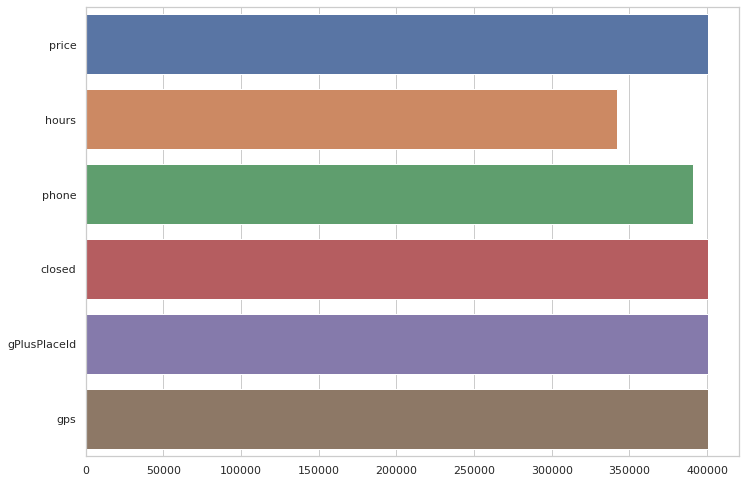

In [9]:
prices_gps_df = df.dropna(subset=['price', 'gps']).drop(columns=['name', 'address'])
print('total places with prices: ', len(prices_gps_df))
num_places_lost = len(prices_address_df) - len(prices_gps_df)
print(f'places lost using gps over address: {num_places_lost}')
print(f'places lost using gps over address: {num_places_lost*100/float(len(prices_address_df)):.2f}%')
num_closed_places = len(prices_gps_df[prices_gps_df.closed == True])
print(f'closed "restaurants": {num_closed_places}')
print(f'closed "restaurants": {num_closed_places*100/len(prices_gps_df):.2f}%')
prices_gps_count_series = prices_gps_df.count()
print(prices_gps_count_series)
sns.barplot(y=prices_gps_count_series.index, x=prices_gps_count_series.values)

### Closed places ( for entire dataset )

In [10]:
closed_series = df['closed']
closed_series.value_counts()

False    3014138
True      100215
Name: closed, dtype: int64

# GPS coordinates

In [17]:
# scale the weird gps coords to normal ones
scale_coords = lambda coord: [coord[0]/1000000, coord[1]/1000000] if abs(coord[0]) > 90 or abs(coord[1]) > 180 else coord

### All places in the dataset (by country)

rows without gps coords: 26951

Num of weird gps coords: 75818

('United States', 1265208)
('India', 155722)
('United Kingdom', 146931)
('Germany', 145877)
('Japan', 119919)
('Canada', 105794)
('France', 99244)
('Spain', 90431)
('Italy', 80676)
('Brazil', 58016) 

CPU times: user 31 s, sys: 617 ms, total: 31.7 s
Wall time: 31.3 s


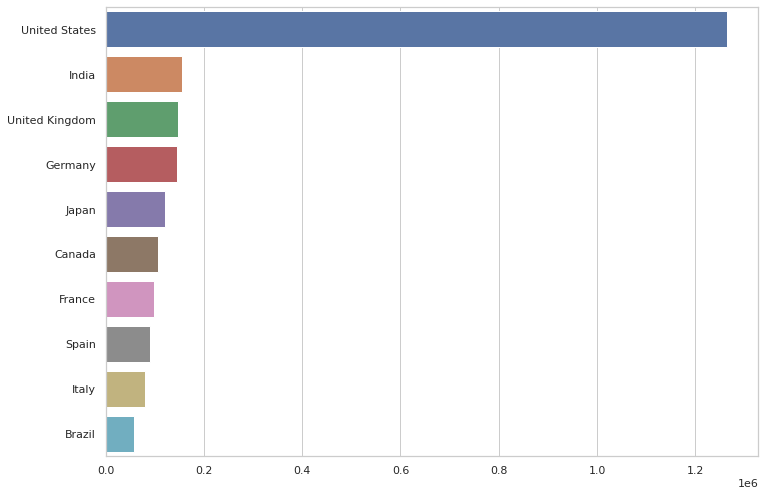

In [18]:
%%time
gps_series = df['gps'].dropna()
print(f'rows without gps coords: {len(df["gps"]) - len(gps_series)}\n')

# eval string to array
intermediate = gps_series.map(eval)

# weird gps coords
weird = [g for g in intermediate if abs(g[0]) > 90 or abs(g[1]) > 180]
print(f'Num of weird gps coords: {len(weird)}\n')

# scale weird coords to standard lat, long
listOfCoords = intermediate.map(scale_coords).to_list()
listOfCities = reverse_geocode.search(listOfCoords)

# count by country
countryCount = Counter([cityState['country'] for cityState in listOfCities])

# top 10 countries with places registered on google
topCountries = sorted(countryCount.most_common(10), key=itemgetter(1), reverse=True)
print('\n'.join([str(t) for t in topCountries]),'\n')

y_axis = [country for country, _ in topCountries]
x_axis = [places for _, places in topCountries]
sns.barplot(y=y_axis, x=x_axis)

del x_axis, y_axis, topCountries, countryCount, listOfCities, listOfCoords, weird, intermediate, gps_series

### Places in dataset with prices ( by country )

Num of weird gps coords: 12761

('United States', 338999)
('United Kingdom', 17757)
('Canada', 10254)
('Australia', 8994)
('Russian Federation', 3526)
('Ghana', 3298)
('Germany', 2446)
('France', 1860)
('Mexico', 1446)
('India', 1189) 

CPU times: user 4.69 s, sys: 153 ms, total: 4.84 s
Wall time: 4.78 s


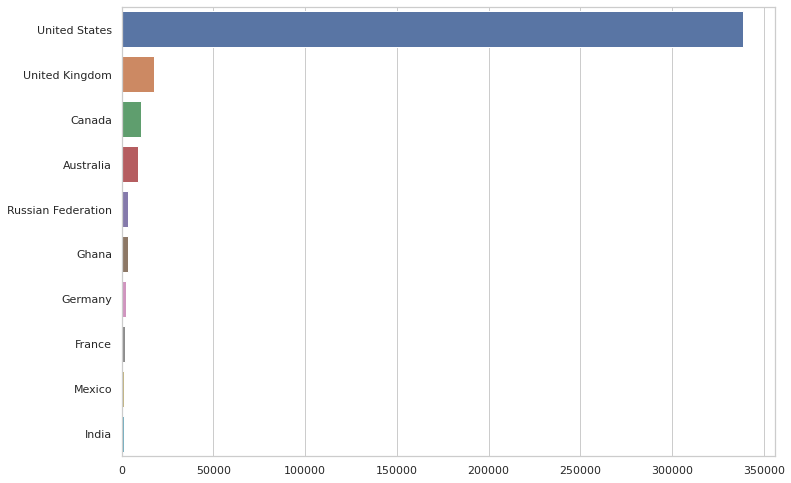

In [19]:
%%time
# rows with both gps and price
gps_prices_series = df.dropna(subset=['gps', 'price'])

# eval string to array
intermediate = gps_prices_series['gps'].map(eval)

# weird gps coords
weird = [g for g in intermediate if abs(g[0]) > 90 or abs(g[1]) > 180]
print(f'Num of weird gps coords: {len(weird)}\n')

# scale weird coords to standard lat, long
listOfCoords = intermediate.map(scale_coords).to_list()
listOfCities = reverse_geocode.search(listOfCoords)

# count by country
countryCount = Counter([cityState['country'] for cityState in listOfCities])

# top 10 countries with places registered on google
topCountries = sorted(countryCount.most_common(10), key=itemgetter(1), reverse=True)
print('\n'.join([str(t) for t in topCountries]),'\n')

y_axis = [country for country, _ in topCountries]
x_axis = [places for _, places in topCountries]
sns.barplot(y=y_axis, x=x_axis)

del x_axis, y_axis, topCountries, countryCount, weird, intermediate, gps_prices_series
# del listOfCoords, listOfCities

### All places in the dataset with "restaurant" category ( by country )

In [20]:
# TBD

### Places in the dataset with prices and "restaurant" category ( by country )

In [21]:
# TBD

### Density of places with prices in USA

In [83]:
%%time
from shapely.geometry import Point

# reverse the coords
f = lambda coord: Point(coord[1], coord[0])

# gps coords - listOfCoords
listOfPoints = map(f, listOfCoords)

# associated city-states - city_states_prices_list
zipped = zip(listOfPoints, listOfCities)

# filter for places in US
g = lambda z: z[1]['country_code'] == 'US'
listOfPointsUS, _ = zip(*filter(g, zipped))

# number of places in US?
print(f'Places in the US: {len(listOfPointsUS)}\n')
gdf = gpd.GeoDataFrame({'geometry': listOfPointsUS})

del listOfPointsUS, g, zipped, listOfPoints, f

Places in the US: 338999

CPU times: user 4.18 s, sys: 109 ms, total: 4.29 s
Wall time: 4.17 s


/home/wardhuang/anaconda3/envs/256-2/lib/python3.8/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


CPU times: user 3min 59s, sys: 2.07 s, total: 4min 1s
Wall time: 3min 58s


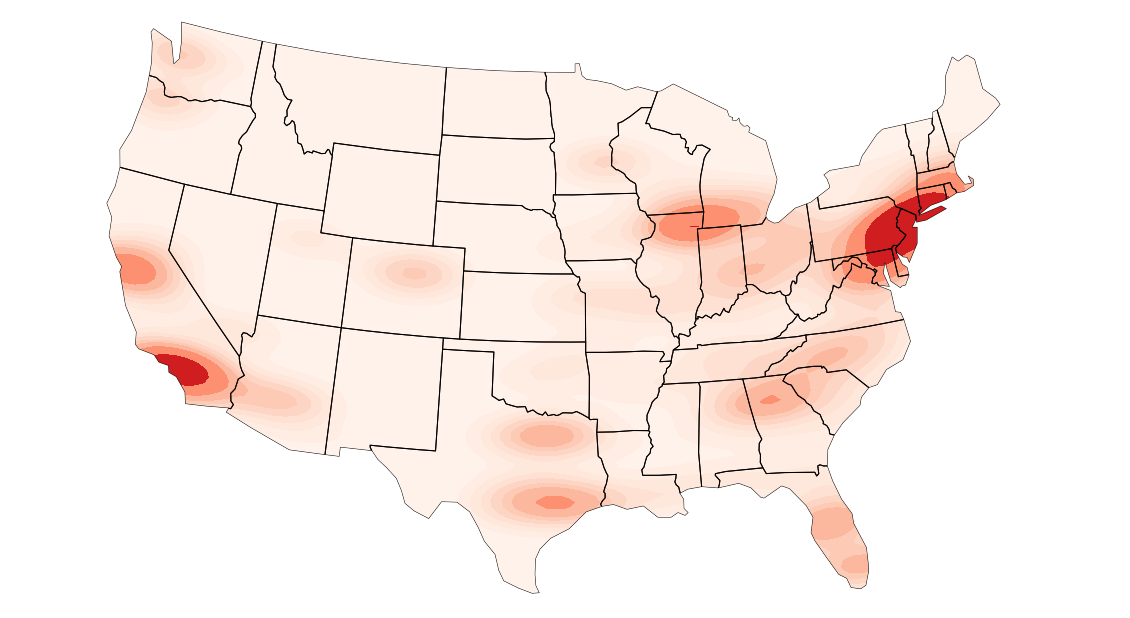

In [84]:
%%time
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
ax = gplt.polyplot(contiguous_usa,
                   projection=gcrs.AlbersEqualArea(),
                   figsize=(20,15),
                   zorder=1)
# 338999 points to plot - 4min
ax = gplt.kdeplot(gdf,
                  ax=ax,
                  cmap='Reds',
                  shade=True,
                  shade_lowest=True,
                  clip=contiguous_usa,
                  extent=contiguous_usa.total_bounds)

# Below code not updated

## Plot of Global GPS Coordinates

### Places with prices and gps and hours

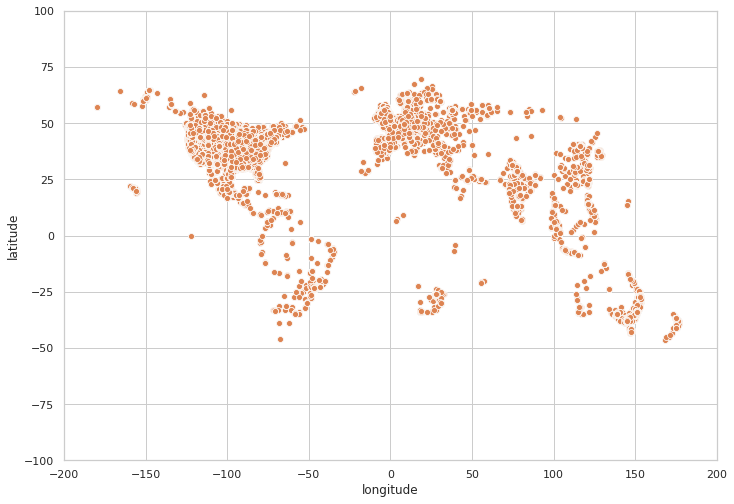

In [61]:
ax = sns.scatterplot(data=gpsDF, x='longitude', y='latitude')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlim(-200,200)
ax.set_ylim(-100,100)
ax = sns.scatterplot(data=gpsDF, x='longitude', y='latitude', ax=ax)

#### Plot of coordinates in North America

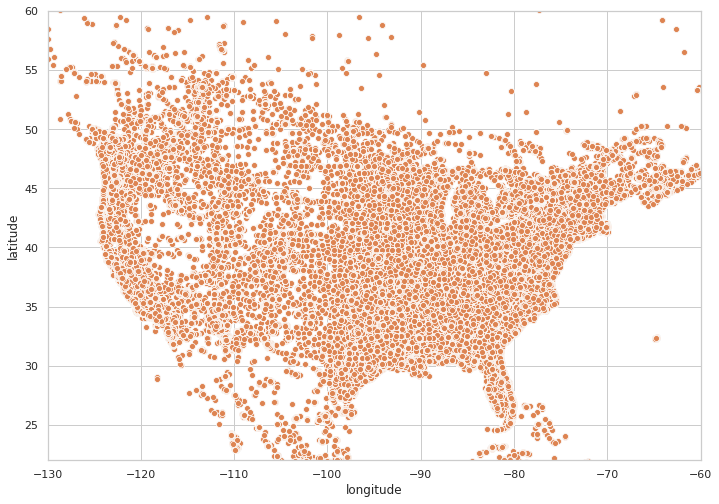

In [79]:
# def is_NA(coord):
#     return coord[0] > 0 and coord[1] < -50
# gps_list_NA = filter(is_NA, gps_list)
gpsObj_NA = { 'latitude': latitude, 'longitude': longitude }
gpsDF_NA = pd.DataFrame(data=gpsObj_NA)
ax = sns.scatterplot(data=gpsDF_NA, x='longitude', y='latitude')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlim(-130,-60)
ax.set_ylim(22,60)
ax = sns.scatterplot(data=gpsDF_NA, x='longitude', y='latitude', ax=ax)

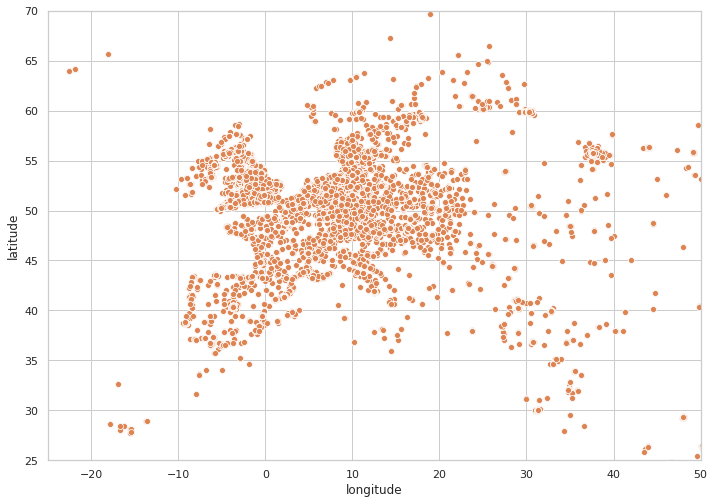

In [76]:
# def is_EU(coord):
#     return coord[0] > 25 and coord[1] > -25 and coord[1] < 50
# gps_list_EU = filter(is_EU, gps_list)
gpsObj_EU = { 'latitude': latitude, 'longitude': longitude }
gpsDF_EU = pd.DataFrame(data=gpsObj_EU)
ax = sns.scatterplot(data=gpsDF_EU, x='longitude', y='latitude')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlim(-25,50)
ax.set_ylim(25,70)
ax = sns.scatterplot(data=gpsDF_EU, x='longitude', y='latitude', ax=ax)